In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter(action="ignore")

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.utils import resample

In [28]:
df = pd.read_csv("./data-collection/Brain_Stroke/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [29]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [12]:
df=df.drop(columns="id")

In [13]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [14]:
df = df.dropna(subset=['bmi'])

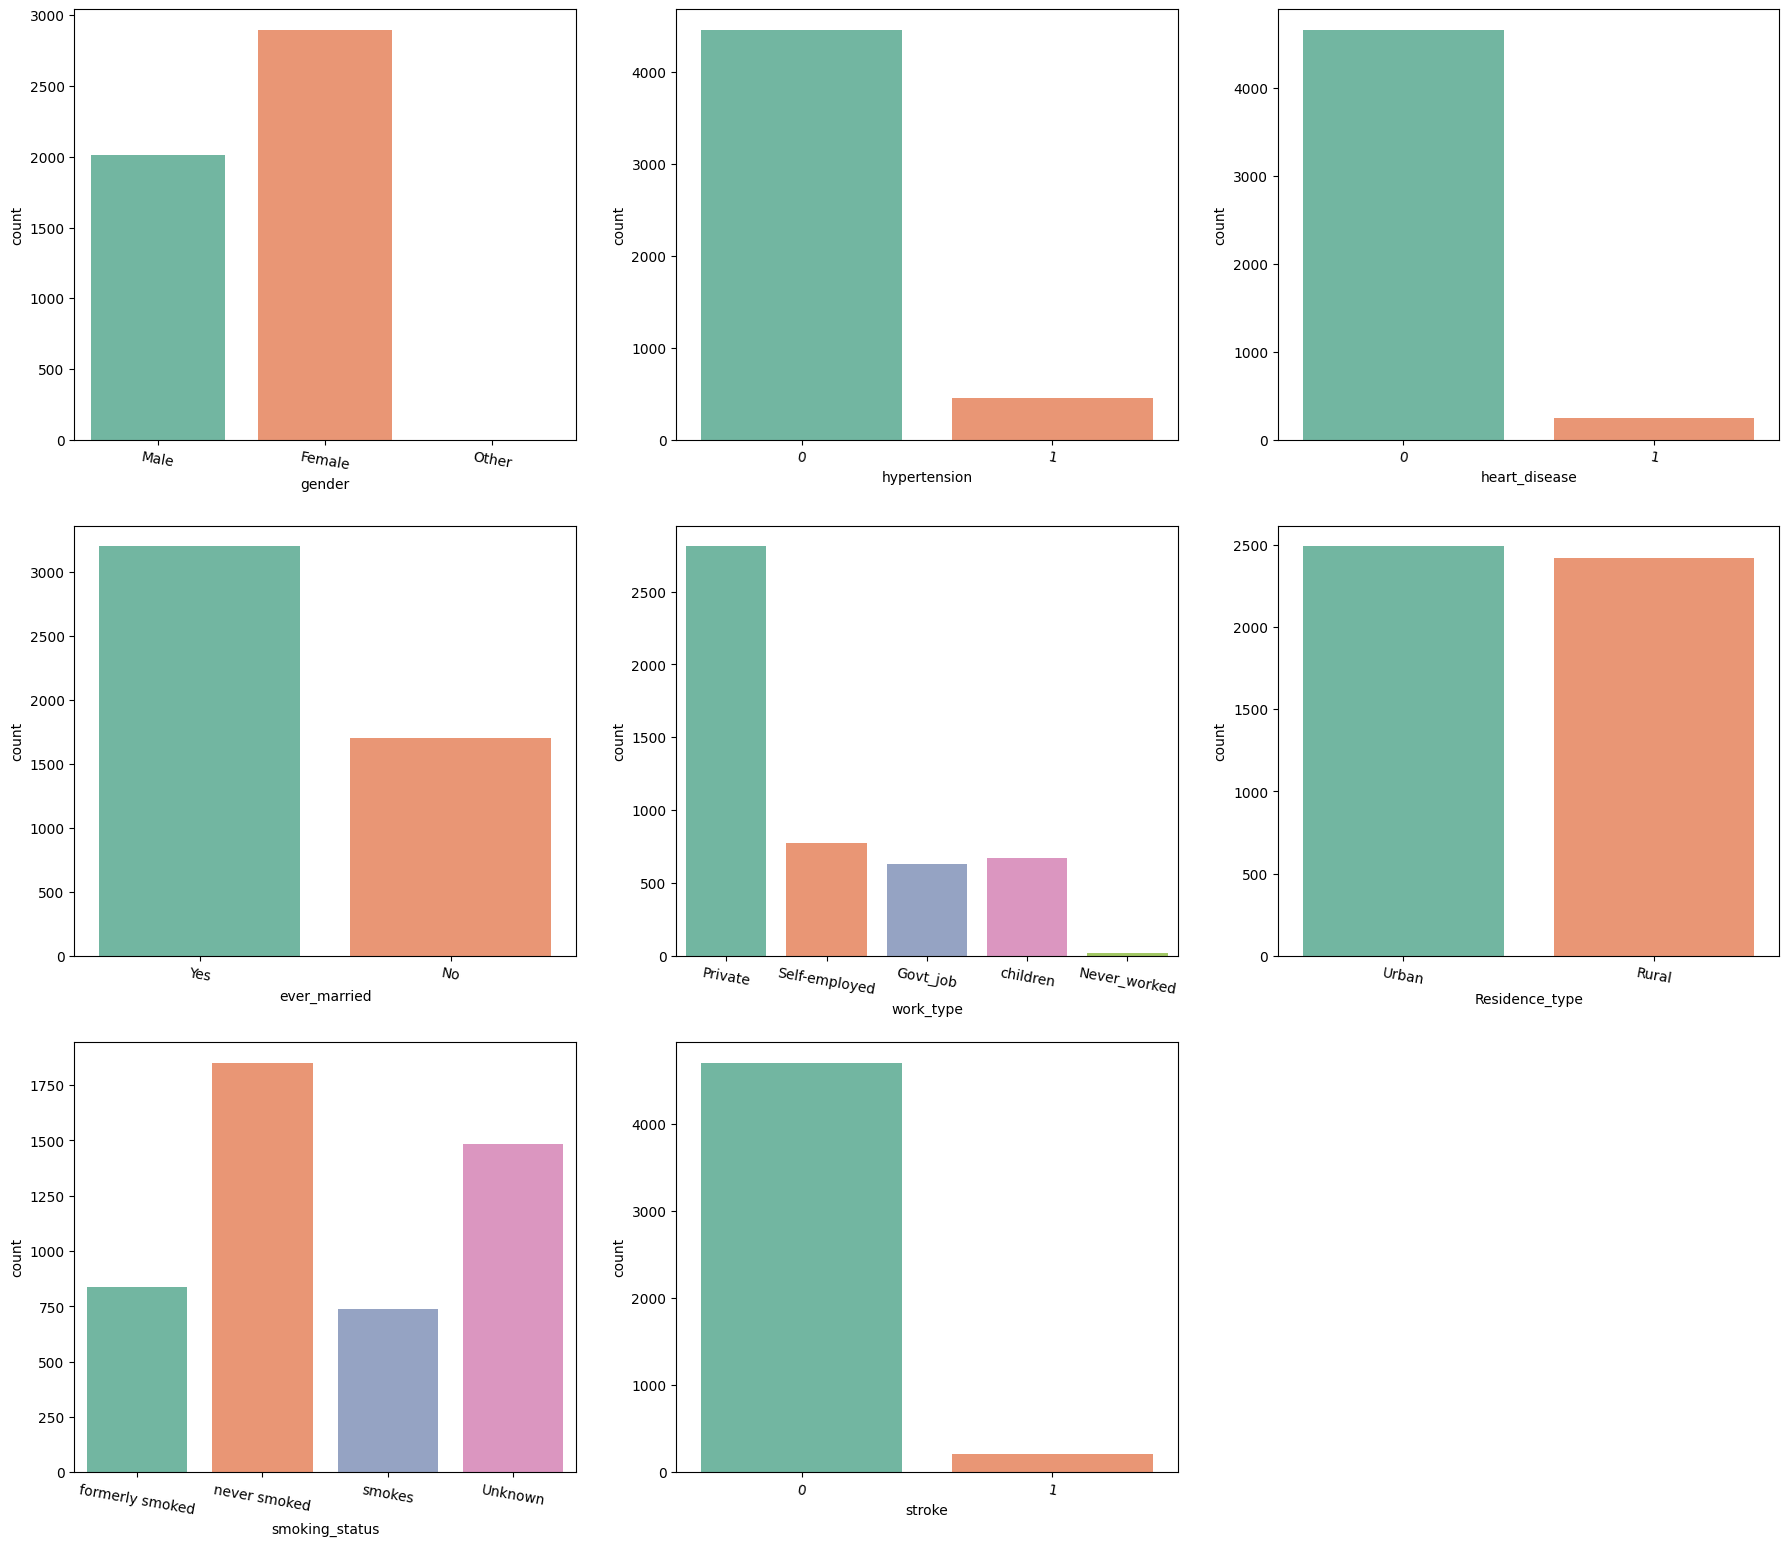

In [68]:
plt.figure(figsize=(22,19))
for i,col in enumerate(df.select_dtypes(exclude=float).columns):
    plt.subplot(3,3,i+1)
    sns.countplot(data=df,x=col,palette =sns.color_palette("Set2"))
    plt.xticks(rotation=-10)

In [15]:
df=df.drop(df[df["gender"]=="Other"].index)

<Axes: >

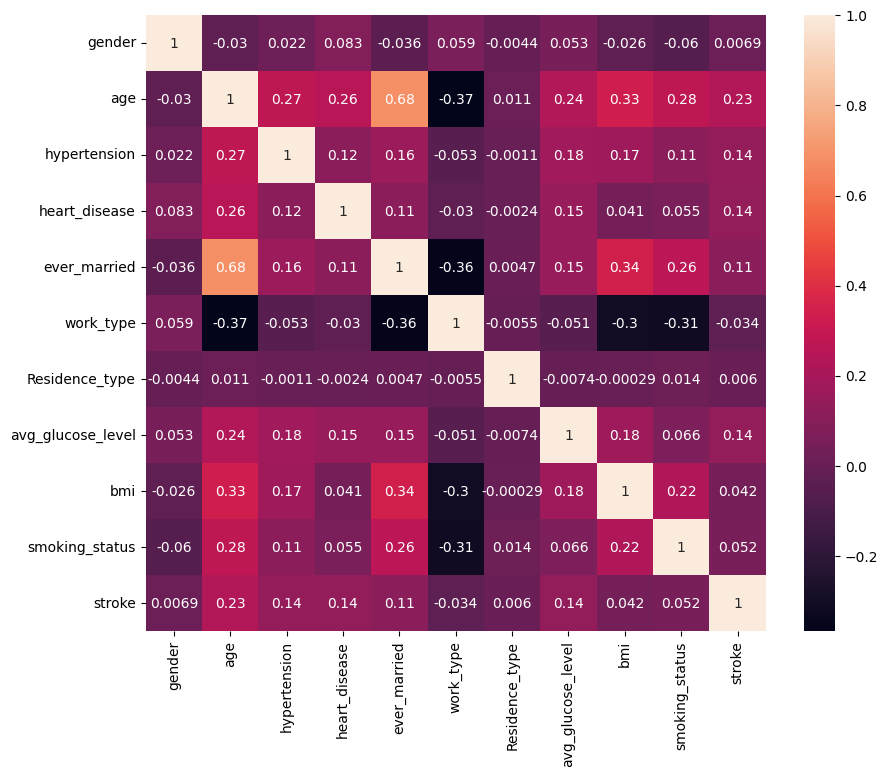

In [70]:
corr_data =df.copy()
encoder  =LabelEncoder()
for col in corr_data.select_dtypes(include="object").columns:
    corr_data[col] =encoder.fit_transform(corr_data[col])

plt.figure(figsize=(10,8))
sns.heatmap(data=corr_data.corr(),annot=True)

In [16]:
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1})


In [17]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,Private,0,228.69,36.6,formerly smoked,1
2,0,80.0,0,1,1,Private,1,105.92,32.5,never smoked,1
3,1,49.0,0,0,1,Private,0,171.23,34.4,smokes,1
4,1,79.0,1,0,1,Self-employed,1,174.12,24.0,never smoked,1
5,0,81.0,0,0,1,Private,0,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,1,13.0,0,0,0,children,1,103.08,18.6,Unknown,0
5106,1,81.0,0,0,1,Self-employed,0,125.20,40.0,never smoked,0
5107,1,35.0,0,0,1,Self-employed,1,82.99,30.6,never smoked,0
5108,0,51.0,0,0,1,Private,1,166.29,25.6,formerly smoked,0


In [18]:
had_stroke = df[df["stroke"]==1]
no_stroke = df[df["stroke"]==0]
upsampled_had_stroke = resample(had_stroke,replace=True , n_samples=no_stroke.shape[0] , random_state=123 )
upsampled_data = pd.concat([no_stroke,upsampled_had_stroke])

<Axes: ylabel='count'>

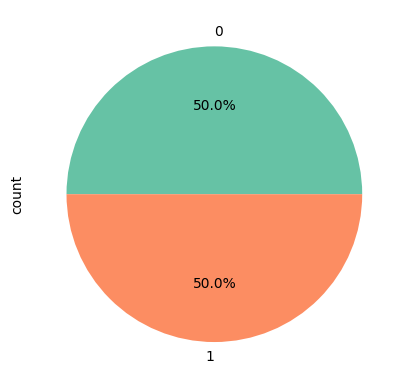

In [19]:
upsampled_data.stroke.value_counts().plot(kind = "pie",autopct="%0.1f%%",colors =sns.color_palette("Set2"))

In [20]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [21]:
cols = ['work_type', 'smoking_status']
dums = pd.get_dummies(upsampled_data[cols],dtype=int)
model_data = pd.concat([upsampled_data,dums],axis=1).drop(columns=cols)

In [76]:
"""scaler = MinMaxScaler()
for col in ['age','avg_glucose_level','bmi']:
    scaler.fit(model_data[[col]])
    model_data[col]=scaler.transform(model_data[[col]])"""

In [22]:
model_data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
249,0,3.0,0,0,0,1,95.12,18.0,0,0,0,0,0,1,1,0,0,0
250,0,58.0,1,0,1,0,87.96,39.2,0,0,0,1,0,0,0,0,1,0
251,1,8.0,0,0,0,0,110.89,17.6,0,0,0,1,0,0,1,0,0,0
252,1,70.0,0,0,1,1,69.04,35.9,0,0,0,1,0,0,0,1,0,0
253,0,14.0,0,0,0,1,161.28,19.1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
100,0,64.0,0,1,1,0,74.10,28.8,1,1,0,0,0,0,1,0,0,0
132,0,69.0,1,0,0,1,182.99,36.5,1,0,0,1,0,0,0,0,1,0
63,1,45.0,0,0,1,1,93.72,30.2,1,0,0,1,0,0,0,1,0,0


In [23]:
# Assuming 'df' is your DataFrame
model_df = model_data.loc[df['stroke'] == 1]
model_df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
131,1,78.0,1,0,0,0,130.54,20.1,1,0,0,1,0,0,0,0,1,0
151,0,68.0,0,1,1,0,223.83,31.9,1,0,0,1,0,0,0,1,0,0
82,1,79.0,0,0,0,1,88.92,22.9,1,0,0,1,0,0,0,0,1,0
117,0,74.0,0,0,1,0,72.96,31.3,1,0,0,1,0,0,0,0,0,1
21,1,52.0,1,0,1,0,233.29,48.9,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
100,0,64.0,0,1,1,0,74.10,28.8,1,1,0,0,0,0,1,0,0,0
132,0,69.0,1,0,0,1,182.99,36.5,1,0,0,1,0,0,0,0,1,0
63,1,45.0,0,0,1,1,93.72,30.2,1,0,0,1,0,0,0,1,0,0


In [24]:
X = model_data.drop(columns="stroke")
y = model_data["stroke"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7,shuffle=True)

In [25]:
from sklearn.metrics import accuracy_score, classification_report

etc_model = ExtraTreesClassifier()
etc_model.fit(X_train,y_train)

ExtraTreesClassifier()

In [26]:
# Make predictions
etc_y_pred = etc_model.predict(X_test)

# Evaluate the model
etc_accuracy = accuracy_score(y_test, etc_y_pred)
etc_class_report = classification_report(y_test, etc_y_pred)

# Print the results
print(f'Extra Tree Classifier Accuracy: {etc_accuracy}')
print('Classification Report:')
print(etc_class_report)

Extra Tree Classifier Accuracy: 0.9973404255319149
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       968
           1       0.99      1.00      1.00       912

    accuracy                           1.00      1880
   macro avg       1.00      1.00      1.00      1880
weighted avg       1.00      1.00      1.00      1880



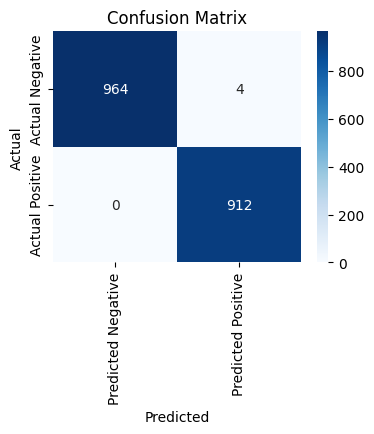

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
etc_conf_matrix = confusion_matrix(y_test, etc_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(etc_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [82]:
rfc_model = RandomForestClassifier(n_estimators=29,max_leaf_nodes=900,max_features=0.8,criterion="entropy")
rfc_model.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_features=0.8,
                       max_leaf_nodes=900, n_estimators=29)

In [83]:
# Make predictions
rfc_y_pred = rfc_model.predict(X_test)

# Evaluate the model
rfc_accuracy = accuracy_score(y_test, rfc_y_pred)
rfc_class_report = classification_report(y_test, rfc_y_pred)

# Print the results
print(f'Random Forest Classifier Accuracy: {rfc_accuracy}')
print('Classification Report:')
print(rfc_class_report)

Random Forest Classifier Accuracy: 0.9925531914893617
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       968
           1       0.98      1.00      0.99       912

    accuracy                           0.99      1880
   macro avg       0.99      0.99      0.99      1880
weighted avg       0.99      0.99      0.99      1880



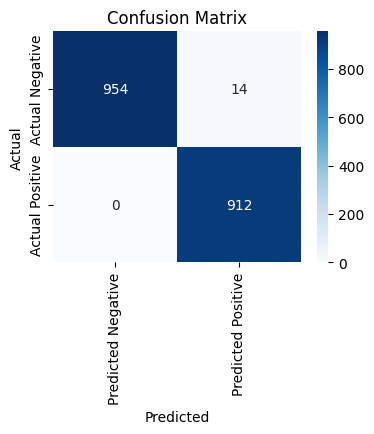

In [84]:
# Generate the confusion matrix
rfc_conf_matrix = confusion_matrix(y_test, rfc_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(rfc_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [85]:
xgb_model = XGBClassifier(objective="binary:logistic",eval_metric = "auc")
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
# Make predictions
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_class_report = classification_report(y_test, xgb_y_pred)

# Print the results
print(f'Random Forest Classifier Accuracy: {xgb_accuracy}')
print('Classification Report:')
print(xgb_class_report)

Random Forest Classifier Accuracy: 0.9835106382978723
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       968
           1       0.97      1.00      0.98       912

    accuracy                           0.98      1880
   macro avg       0.98      0.98      0.98      1880
weighted avg       0.98      0.98      0.98      1880



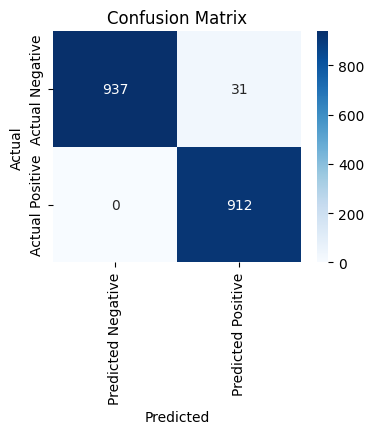

In [87]:
# Generate the confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [88]:
gbc_model = GradientBoostingClassifier(max_depth=29,min_samples_leaf=4,min_samples_split=13,subsample=0.8)
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=29, min_samples_leaf=4,
                           min_samples_split=13, subsample=0.8)

In [89]:
# Make predictions
gbc_y_pred = gbc_model.predict(X_test)

# Evaluate the model
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_class_report = classification_report(y_test, gbc_y_pred)

# Print the results
print(f'Gradient Boosting Classifier Accuracy: {gbc_accuracy}')
print('Classification Report:')
print(gbc_class_report)

Gradient Boosting Classifier Accuracy: 0.9952127659574468
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       968
           1       0.99      1.00      1.00       912

    accuracy                           1.00      1880
   macro avg       1.00      1.00      1.00      1880
weighted avg       1.00      1.00      1.00      1880



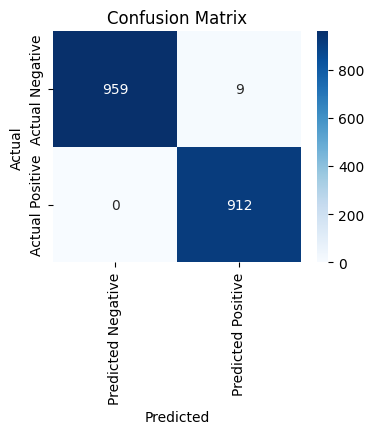

In [90]:
# Generate the confusion matrix
gbc_conf_matrix = confusion_matrix(y_test, gbc_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(gbc_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()